### Pseudo code

Read in scRNA data

X=scRNA.X count matrix

Y=scRNA.obs dbscan (hand annotated labels)

Train, validation, test split 

Shuffle 

**Train model over N epoches with batches**

    For each epoch 
    
        For each batch within an epoch
        
            1. Store every 1000 batch's latent space --> Silhouette score on latent space to true labels
            
            2. Train loss (reconstr + KL lower bound)
            
        At the end of each epoch evaluate on validation:
        
        1. Validation latent space transform_rna(train_x) --> silhouette score
        
        2. Reconstruct validation set --> MSE (to original validation data)


### Grid search for best learning rate, learning rate decay, loss weights, 

        
**Evaluate on test set**        
        
1. Validation latent space transform_rna(train_x) --> silhouette score
        
2. Reconstruct validation set --> MSE (to original validation data)
       

In [72]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
import os
import functools
from sklearn import metrics
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, f1_score, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import silhouette_samples, silhouette_score
from tqdm.notebook import tqdm
import scanpy as sc
from collections import Counter
import matplotlib.cm as cm
from anndata import AnnData
import itertools as it

import scTrans
from scTrans import scTranslate

### Data preparation

In [9]:
scrna=sc.read_h5ad("/Users/yaoestelle/scRNA_mit.h5ad")

In [10]:
scrna_full=scrna.X
scrna_label=scrna.obs.dbscan.values

In [11]:
Counter(scrna.obs['dbscan'])

Counter({1: 7018,
         2: 826,
         3: 22610,
         4: 3188,
         5: 1191,
         6: 3570,
         7: 5946,
         8: 811,
         9: 597,
         10: 332})

In [12]:
##Train test split
validation_percent = 0.20
x_train, test_x, y_train, test_y  = train_test_split(scrna_full, scrna_label,
                                                     test_size=validation_percent,
                                                     stratify = scrna_label)

In [86]:
##Train val split
train_x, val_x, train_y, val_y = train_test_split(x_train, y_train,
                                                  test_size=validation_percent,
                                                  stratify=y_train)

In [26]:
train_x.shape, train_y.shape, val_x.shape

((29496, 3000), (29496,), (7375, 3000))

In [21]:
len(Counter(train_y)), len(Counter(val_y))

(10, 10)

In [27]:
###Downsample for test run 
train_x=train_x[:4000,]
train_y=train_y[:4000]
val_x=val_x[:1000,]
val_y=val_y[:1000]
train_x.shape, train_y.shape, val_x.shape

### Training

In [87]:
###Hyper paramter

def intialize_model(X, n_latent, 
                    learning_rate = 1e-4, learning_rate_decay = 0.99999,
                    lambda_latent = 1e-2, lambda_reconst_rna = 1e-3):

    #n_latent = 50
    network_architecture = {
        "n_input_rna": X.shape[1],
        "n_input_atac": X.shape[1],
        "n_hidden_recog_1": 250,
        "n_hidden_recog_2": 100,
        "n_hidden_recog_3": 100,
        "n_hidden_gener_1": 100,
        "n_hidden_gener_2": 100,
        "n_hidden_gener_3": 100,
        "rna_n_z": n_latent,
        "atac_n_z": n_latent
    }

    tf.compat.v1.disable_eager_execution()
    sct = scTranslate(network_architecture, 
                      transfer_fct =tf.nn.relu,  # .nn.relu,identity
                      learning_rate = learning_rate,  
                      learning_rate_decay = learning_rate_decay,
                      lambda_latent = lambda_latent, 
                      lambda_reconst_rna = lambda_reconst_rna,

                      batch_size=16,
                      lambda_nonzero=0, 
                      lambda_reconst_atac=1e-3,
                      lambda_trans=1e-3, 
                      lambda_atac_cross=1e0, lambda_rna_cross=1e-3,
                      bound_atac_output=False)
    return sct

In [88]:
### Training loop 

def scRNA_train(sct , ###scTranslate class 
                x_train, y_train, x_val, y_val ,num_epochs, batch_size):
    
    ##Progress bar
    pbar = functools.partial(tqdm, leave=True, ncols='70%')
    pbars = [pbar() for _ in range(2)]
    
    history_train={'latent':[], 'cost':[], 'y_train':[]}
    history_val={'latent':[], 'cost':[]}
    
    for epoch in range(num_epochs):
        
        shuffle_index=np.arange(x_train.shape[0])
        np.random.shuffle(shuffle_index)
        shuffle_x = x_train[shuffle_index]
        shuffle_y = y_train[shuffle_index]
        
        total_batch = int(x_train.shape[0] / batch_size)

        pbars[1].reset(total=total_batch)

        for step in range(total_batch):
            
            offset = (step * batch_size) % (x_train.shape[0] - batch_size)
            batch_x = shuffle_x[offset:(offset + batch_size), :]
            
            ##training step --> update weights
            cost=sct.train_rna(batch_x)
            
            pbars[1].update()
        
        ##Record latent space per epoch
        ##Last batch of the epoch = epoch loss
        ##cost= resonstruct loss + latent loss 
        rna_train_latent=sct.transform_rna(shuffle_x)
        history_train['latent'].append(rna_train_latent)
        history_train['cost'].append(cost)
        history_train['y_train'].append(shuffle_y)
        
        pbars[0].update()
        
        ###Validation
        rna_val_reconstruct = sct.reconstruct_rna(x_val)
        rna_val_latent=sct.transform_rna(x_val)
        ##validation loss per epoch
        val_epoch_loss=np.mean(np.sum(np.square(x_val-rna_val_reconstruct),axis=1))
        
        history_val['cost'].append(val_epoch_loss)
        history_val['latent'].append(rna_val_latent)
        
        ##print epoch weight
        print(f"Epoch: {epoch}, Train loss: {cost}, Validation loss: {val_epoch_loss}")
    
    return [history_train, history_val]

In [89]:
def scRNA_loss(history_train, history_val):
    
    ###Loss function trajectory
    train_cost = history_train['cost']
    val_cost = history_val['cost']
    
    ##Line plot visuzlie loss per epoch 
    fig, ax = plt.subplots(1,2, figsize=(11, 6.5)) 
    ax[0].scatter(np.arange(len(train_cost)),train_cost)
    ax[0].plot(np.arange(len(train_cost)),train_cost)
    ax[0].set_xlabel("Epochs", fontsize=12)
    ax[0].set_ylabel("Training loss", fontsize=12)
    ax[0].set_title("Training loss (Reconstruction + Latent Loss)", fontsize=14)
    
    ax[1].scatter(np.arange(len(val_cost)),val_cost)
    ax[1].plot(np.arange(len(val_cost)),val_cost)
    ax[1].set_xlabel("Epochs", fontsize=12)
    ax[1].set_ylabel("Validation loss", fontsize=12)
    ax[1].set_title("Validation loss (Reconstruction Loss)", fontsize=14)
    
    fig.suptitle("Visualization of loss across epochs",fontsize=16,y=1)
    plt.tight_layout()
    plt.show()    

In [90]:
def scRNA_silhouette(history_train, history_val, val_y , epoch_num):
    
    ###Latent space 
    train_latent = history_train['latent'][epoch_num]
    train_y = history_train['y_train'][epoch_num]
    
    val_latent = history_val['latent'][epoch_num]
    
    ###Calculate silhouette score per sample
    train_sil=silhouette_samples(train_latent, train_y)
    val_sil=silhouette_samples(val_latent, val_y)
    
    n_clusters=len(Counter(train_y).keys())
    
    ###Plot silhouette score for train and test 
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)
        
    ax1.set_xlim([-0.1, 1])
    ax1.set_ylim([0, len(train_latent) + (n_clusters + 1) * 10])
    
    ax2.set_xlim([-0.1, 1])
    ax2.set_ylim([0, len(val_latent) + (n_clusters + 1) * 10])
         
    y_lower = 10
    val_y_lower = 10
    for i in range(n_clusters):
        
        #############################################################
        ###############Training 
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        train_ith_cluster_silhouette_values = train_sil[train_y == i]
        train_ith_cluster_silhouette_values.sort()
        
        size_cluster_i = train_ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, train_ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples
        
        #############################################################
        ###############Validation 
        val_ith_cluster_silhouette_values = val_sil[val_y == i]
        val_ith_cluster_silhouette_values.sort()
        
        val_size_cluster_i = val_ith_cluster_silhouette_values.shape[0]
        val_y_upper = val_y_lower + val_size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax2.fill_betweenx(np.arange(val_y_lower, val_y_upper),
                          0, val_ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax2.text(-0.05, val_y_lower + 0.5 * val_size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        val_y_lower = val_y_upper + 10  # 10 for the 0 samples
     
    ax1.set_title("Training silhouette plot for known labels")
    ax1.set_xlabel("Silhouette coefficient values")
    ax1.set_ylabel("Cluster label")
    
    ax2.set_title("Validation silhouette plot for known labels")
    ax2.set_xlabel("Silhouette coefficient values")
    ax2.set_ylabel("Cluster label")
    
    # The vertical line for average silhouette score of all the values
    train_avg=silhouette_score(train_latent, train_y)
    val_avg=silhouette_score(val_latent, val_y)
    
    ax1.axvline(x=train_avg, color="red", linestyle="--")
    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
    
    ax2.axvline(x=val_avg, color="red", linestyle="--")
    ax2.set_yticks([])  # Clear the yaxis labels / ticks
    ax2.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
    
    plt.suptitle("Silhouette scores for VAE latent space", fontsize=14, fontweight='bold')
    plt.show()           

In [99]:
def scRNA_latent(history_train, history_val, val_y , epoch_num):
    
    ###Latent space 
    train_latent = history_train['latent'][epoch_num]
    train_y = history_train['y_train'][epoch_num]
    
    val_latent = history_val['latent'][epoch_num]
    
    train_adata = AnnData(train_latent) 
    
    train_adata.obs['ground_truth'] = train_y
    train_adata.obs['ground_truth'] = pd.Categorical(train_adata.obs['ground_truth'])
    sc.pp.neighbors(train_adata, n_neighbors=15, use_rep='X')
    sc.tl.umap(train_adata)
    sc.pl.umap(train_adata, color=['ground_truth'],size=50, title="Training embedding")
    
    val_adata = AnnData(val_latent)
    val_adata.obs['ground_truth'] = val_y
    val_adata.obs['ground_truth'] = pd.Categorical(val_adata.obs['ground_truth'])
    sc.pp.neighbors(val_adata, n_neighbors=15, use_rep='X')
    sc.tl.umap(val_adata)
    sc.pl.umap(val_adata, color=['ground_truth'],size=50, title="Validation embedding")

### Test model training  

In [105]:
num_epochs=10
batch_size=64
n_latent=50

In [103]:
model=intialize_model(train_x, n_latent, learning_rate = 0.1, 
                      learning_rate_decay = 0.99999,
                      lambda_latent = 1e-2, lambda_reconst_rna = 1e-3)

In [104]:
model

In [106]:
history_train, history_val = scRNA_train(model , 
                                         train_x,  train_y,val_x, val_y ,num_epochs, batch_size)

0it [00:00, ?it/s]

0it [00:00, ?it/s]

Epoch: 0, Train loss: 8.78565788269043, Validation loss: 8640.952504086055
Epoch: 1, Train loss: 10.010330200195312, Validation loss: 7840.871188755898
Epoch: 2, Train loss: 8.482831954956055, Validation loss: 7604.570415629679
Epoch: 3, Train loss: 7.783790111541748, Validation loss: 7650.904001517858
Epoch: 4, Train loss: 9.853605270385742, Validation loss: 7666.267431621577
Epoch: 5, Train loss: 6.619032382965088, Validation loss: 7079.885888806475
Epoch: 6, Train loss: 6.440624237060547, Validation loss: 6850.695440329205
Epoch: 7, Train loss: 6.111123561859131, Validation loss: 6731.844640018532
Epoch: 8, Train loss: 8.928987503051758, Validation loss: 6640.272615983752
Epoch: 9, Train loss: 5.176590442657471, Validation loss: 6498.677221359737


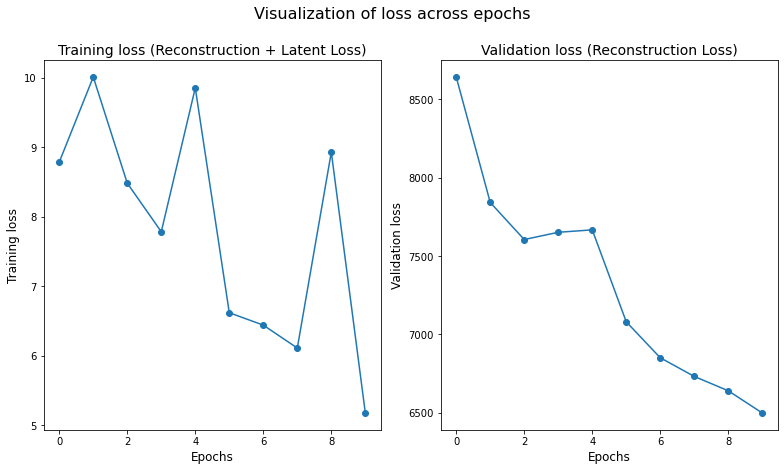

In [107]:
scRNA_loss(history_train, history_val)

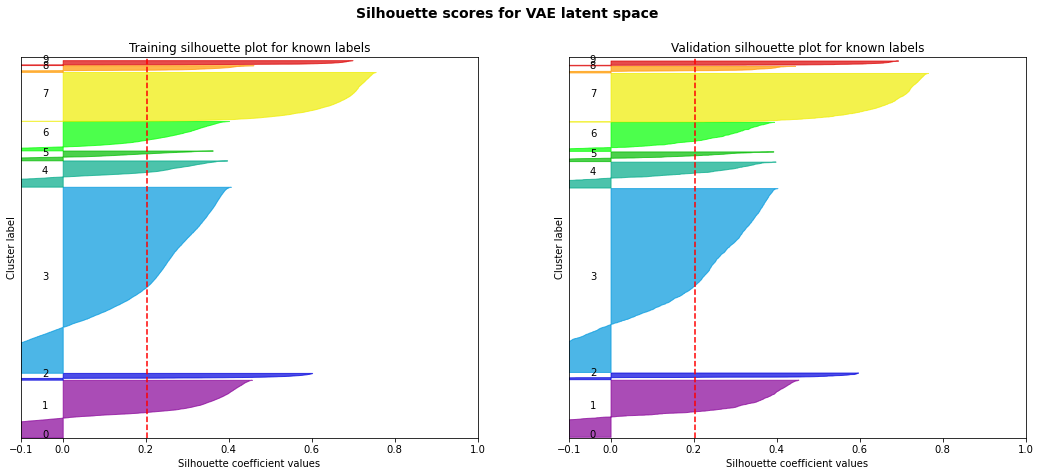

In [108]:
scRNA_silhouette(history_train, history_val, val_y , epoch_num=9)

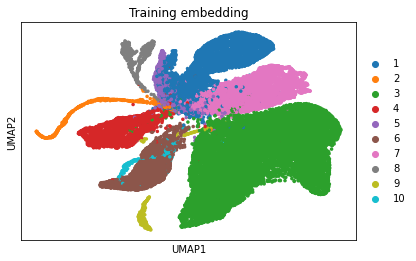

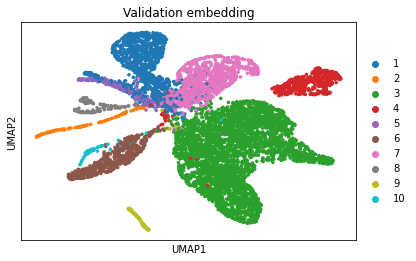

In [109]:
scRNA_latent(history_train, history_val, val_y , epoch_num=9)

### Grid search + Test time 

In [101]:
Hyper_grid={'n_latent':range(50,100,10),
            'learning_rate':[1e-4, 1e-3, 1e-2],
            'lambda_latent':[1e-2, 1e-1, 1e-3],
            'lambda_reconst_rna':[1e-4, 1e-3, 1e-2]
           }

num_epochs=100
batch_size=64

def grid_search(Hyper_grid):
    hyperparam_combos = list(it.product(Hyper_grid['n_latent'], 
                                        Hyper_grid['learning_rate'],
                                        Hyper_grid['lambda_latent'],
                                        Hyper_grid['lambda_reconst_rna']))
    pbar = functools.partial(tqdm, leave=True, ncols='70%')
    pbars = [pbar() for _ in range(1)]
    pbars[0].reset(len(hyperparam_combos))
    pbars[0].set_description('Grid Search')
    
    losses=[]
    for n_latent, learning_rate, lambda_latent, lambda_reconst_rna in hyperparam_combos:
        
        model=intialize_model(train_x, n_latent, learning_rate = learning_rate, 
                              learning_rate_decay = 0.99999,
                              lambda_latent = lambda_latent, lambda_reconst_rna = lambda_reconst_rna)
        
        history_train, history_val = scRNA_train(model , train_x,  train_y,val_x, val_y ,num_epochs, batch_size)
        
        InteractiveSession.close()
        
        best_loss=min(history_val['cost'])
        
        losses.append([n_latent, learning_rate, lambda_latent, lambda_reconst_rna, best_loss])
        
        pbars[0].update()  
    
    return losses

In [102]:
# Hyper_grid={'n_latent':[50,100],
#             'learning_rate':[1e-4],
#             'lambda_latent':[1e-2],
#             'lambda_reconst_rna':[1e-4]
#            }
losses=grid_search(Hyper_grid)

0it [00:00, ?it/s]

/Users/yaoestelle/opt/anaconda3/envs/cs109b/lib/python3.8/site-packages/tensorflow/python/client/session.py:1761: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Epoch: 0, Train loss: 0.9545318484306335, Validation loss: 8710.856136167216
Epoch: 1, Train loss: 1.1099611520767212, Validation loss: 8708.53417153979
Epoch: 2, Train loss: 0.9932323694229126, Validation loss: 8706.896642800384
Epoch: 3, Train loss: 0.9611914157867432, Validation loss: 8705.678847143945
Epoch: 4, Train loss: 1.2699213027954102, Validation loss: 8704.733039775992
Epoch: 5, Train loss: 0.8815027475357056, Validation loss: 8703.978035371854
Epoch: 6, Train loss: 0.8402150273323059, Validation loss: 8703.364150633663
Epoch: 7, Train loss: 0.7568809986114502, Validation loss: 8702.858575557832
Epoch: 8, Train loss: 0.8497778177261353, Validation loss: 8702.430800426202
Epoch: 9, Train loss: 0.8652194738388062, Validation loss: 8702.062511411426
Epoch: 10, Train loss: 1.1385866403579712, Validation loss: 8701.743297503579
Epoch: 11, Train loss: 0.7330054044723511, Validation loss: 8701.464131058348
Epoch: 12, Train loss: 0.7896168231964111, Validation loss: 8701.2170438134

KeyboardInterrupt: 

In [85]:
pd.DataFrame(losses, columns=['n_latent','learning_rate','lambda_latent','lambda_reoncst','Reconstruction loss'])

,n_latent,learning_rate,lambda_latent,lambda_reoncst,Reconstruction loss
0,50,0.0001,0.01,0.0001,9000.966659
1,100,0.0001,0.01,0.0001,9006.908579


#### To do 

After finding the best combination of hyper paramters, retrain the model for the best model

Then test on test set